In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import glob
import natsort
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
from preprocess import get_cortex
import cfhcpy
from cfhcpy.base import AnalysisBase
import pandas as pd
import h5py
from scipy.stats import sem
from scipy.stats import f_oneway
import scikit_posthocs as sp
from copy import deepcopy

In [3]:
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]



roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159, 'MIP': 50
    }


roi_index_dict2 = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3AB': [13, 19], 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'MST': 2, 'MT': 23, 'LO': [20, 21,  159]
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


    
boolmask = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_mask_hcp.npy')

In [ ]:
# def load_wang(space, wcard='{hem}.wang_{space}.label.gii',wangloc='/tank/klundert/fsphere/'):
#     ldat,rdat=nib.load(os.path.join(wangloc,wcard.format(hem='L',space=space))),nib.load(os.path.join(wangloc,wcard.format(hem='R',space=space)))
#     fulldat=np.concatenate([ldat.agg_data(),rdat.agg_data()])
#     return fulldat

# atlas_data = load_wang('HCP')

# roi_index_dict = {
#     'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'hV4':  7, 'VO1':  8, 'VO2':  9, 'PHC1':  10, 'PHC2':  11,
#     'TO2':  12, 'TO1':  13, 'LO2':  14, 'LO1':  15, 'V3B':  16, 'V3A':  17, 'IPS0':  18, 'IPS1':  19, 'IPS2':  20, 'IPS3':  21, 'IPS4': 22,
#     'IPS5':  23, 'SPL1':  24, 'FEF': 25}


# # boolmask = atlas_data_both_hemis == roi_index_dict['V1']
# # for i, ROIs in enumerate(ind):
# #     boolmask = np.array(atlas_data_both_hemis == ind[i]) + boolmask
# #     print(ROIs)


# roimask = np.isin(atlas_data, roi_index_dict['V2'])
# for l, ROI in enumerate(list(roi_index_dict)[1:]):
#     roimask = np.isin(atlas_data, roi_index_dict[ROI]) + roimask
    
# V3mask = np.isin(atlas_data, roi_index_dict['V3'])

In [28]:
def get_blend(Vertex, threshold=0, brightness=0.6,
                    contrast=0.25, smooth=20):
    """Blend the data with a curvature map depending on a transparency map.

    Vertex objects cannot use transparency as Volume objects. This method
    is a hack to mimic the transparency of Volume objects, blending the
    Vertex data with a curvature map. This method returns a VertexRGB
    object, and the colormap parameters (vmin, vmax, cmap, ...) of the
    original Vertex object cannot be changed later on.
    Parameters
    ----------
    Vertex : Vertex you want to plot
        Vertex you want to plot.
    alpha : array of shape (n_vertices, )
        Transparency map.
    threshold : float
        Threshold for the curvature map.
    brightness : float
        Brightness of the curvature map.
    contrast : float
        Contrast of the curvature map.
    smooth : float
        Smoothness of the curvature map.

    Returns
    -------
    blended : VertexRGB object
        The original map blended with a curvature map.
    """
    
    alpha = (~np.isnan(Vertex.data)).astype("float")

    curvature = cx.db.get_surfinfo('hcp_999999').data
    curvature = (curvature > 0).astype("float")
    curvature = curvature * contrast + brightness
    curvature_raw = cx.Vertex(curvature, subject='hcp_999999', vmin=0, vmax=1, cmap='gray').raw
    alpha = np.clip(alpha, 0, 1)  
    blended = deepcopy(Vertex.raw)  # copy because VertexRGB.raw returns self
    blended.red.data = blended.red.data * alpha + (1 - alpha) * curvature_raw.red.data
    blended.green.data = blended.green.data * alpha + (1 - alpha) * curvature_raw.green.data
    blended.blue.data = blended.blue.data * alpha + (1 - alpha) * curvature_raw.blue.data
    blended.red.data = blended.red.data.astype("uint8")
    blended.green.data = blended.green.data.astype("uint8")
    blended.blue.data = blended.blue.data.astype("uint8")

    
    return blended

In [29]:
def add_sign_plot_bar():
    vh = 0.08
    hh = 0.11
    barh = np.amax([np.nanmean(rdiff[boolmask2]), np.nanmean(rdiff2[boolmask2]), np.nanmean(rdiff3[boolmask2])])
    if tt[2][3] < 0.05:
        
        plt.plot([l+width*2,l+width*2], [barh+hh, barh+vh], c='cornflowerblue')
        plt.plot([l+width,l+width], [barh+hh, barh+vh], c='coral')
        plt.plot([l+width,l+width*2], [barh+hh, barh+hh], c='black')
        pval_str = ""
        if tt[2][3] < 0.05:
            pval_str+="*"
            if tt[2][3] < 0.01:
                pval_str+="*"
                if tt[2][3] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."
        plt.text(l+width*1.2, barh+hh+0.01, pval_str, weight = 'bold',)

        vh = vh + 0.1
        hh = hh + 0.1
    
    if tt[2][1] < 0.05:

        plt.plot([l+width,l+width], [barh+hh, barh+vh], c='coral')
        plt.plot([l,l], [barh+hh, barh+vh], c='teal')
        plt.plot([l,l+width], [barh+hh, barh+hh], c='black')

        pval_str = ""
        if tt[2][1] < 0.05:
            pval_str+="*"
            if tt[2][1] < 0.01:
                pval_str+="*"
                if tt[2][1] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."
        plt.text(l, barh+hh+0.01, pval_str, weight = 'bold')

        vh = vh + 0.1
        hh = hh + 0.1

    if tt[3][1] < 0.05:
    
        plt.plot([l+width*2,l+width*2], [barh+hh, barh+vh], c='cornflowerblue')
        plt.plot([l,l], [barh+hh, barh+vh], c='teal')
        plt.plot([l,l+width*2], [barh+hh, barh+hh], c='black')

        pval_str = ""
        if tt[3][1] < 0.05:
            pval_str+="*"
            if tt[3][1] < 0.01:
                pval_str+="*"
                if tt[3][1] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."

        plt.text(l+width/2, barh+hh+0.01, pval_str, weight = 'bold')
        
        
        
def add_sign_plot_bar2():
    vh = 0.08
    hh = 0.11
    barh = np.amax([np.nanmean(rdiff[boolmask2]), np.nanmean(rdiff2[boolmask2])])

    
    if tt[2][1] < 0.05:

        plt.plot([l+width,l+width], [barh+hh, barh+vh], c='coral')
        plt.plot([l,l], [barh+hh, barh+vh], c='teal')
        plt.plot([l,l+width], [barh+hh, barh+hh], c='black')

        pval_str = ""
        if tt[2][1] < 0.05:
            pval_str+="*"
            if tt[2][1] < 0.01:
                pval_str+="*"
                if tt[2][1] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."
        plt.text(l, barh+hh+0.01, pval_str, weight = 'bold')

        vh = vh + 0.1
        hh = hh + 0.1

    
def add_sign_plot_violin():
    vh = 0.08
    hh = 0.11
    barh = np.amax([np.nanmax(rdiff[boolmask2]), np.nanmax(rdiff2[boolmask2]), np.nanmax(rdiff3[boolmask2])])
    if tt[2][3] < 0.05:
        
        plt.plot([l+width*2,l+width*2], [barh+hh, barh+vh], c='cornflowerblue')
        plt.plot([l+width,l+width], [barh+hh, barh+vh], c='coral')
        plt.plot([l+width,l+width*2], [barh+hh, barh+hh], c='black')
        pval_str = ""
        if tt[2][3] < 0.05:
            pval_str+="*"
            if tt[2][3] < 0.01:
                pval_str+="*"
                if tt[2][3] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."
        plt.text(l+width*1.2, barh+hh+0.01, pval_str, weight = 'bold',)

        vh = vh + 0.1
        hh = hh + 0.1
    
    if tt[2][1] < 0.05:

        plt.plot([l+width,l+width], [barh+hh, barh+vh], c='coral')
        plt.plot([l,l], [barh+hh, barh+vh], c='teal')
        plt.plot([l,l+width], [barh+hh, barh+hh], c='black')

        pval_str = ""
        if tt[2][1] < 0.05:
            pval_str+="*"
            if tt[2][1] < 0.01:
                pval_str+="*"
                if tt[2][1] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."
        plt.text(l, barh+hh+0.01, pval_str, weight = 'bold')

        vh = vh + 0.1
        hh = hh + 0.1

    if tt[3][1] < 0.05:
    
        plt.plot([l+width*2,l+width*2], [barh+hh, barh+vh], c='cornflowerblue')
        plt.plot([l,l], [barh+hh, barh+vh], c='teal')
        plt.plot([l,l+width*2], [barh+hh, barh+hh], c='black')

        pval_str = ""
        if tt[3][1] < 0.05:
            pval_str+="*"
            if tt[3][1] < 0.01:
                pval_str+="*"
                if tt[3][1] < 0.001:
                    pval_str+="*"
        else:
            pval_str+="n.s."

        plt.text(l+width/2, barh+hh+0.01, pval_str, weight = 'bold')

In [30]:
## data average all folds/subs for each model plus add the average x and y values

all_data_cf_cortical = []
all_data_cf_vis = []
all_data_cf_logvis = []
all_data_dncf_cortical = []
all_data_dncf_vis = []
all_data_dncf_logvis = []

for i, sub in enumerate([2]):
    gauss_prf = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/gaussian-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy'))

    x, y = gauss_prf[:,0], gauss_prf[:,1]
    d = {'x': x, 'y': y}
    ret_frame = pd.DataFrame(data=d)
    for model in ['CF_cortical', 'CF_vis', 'CF_logvis', 'DNCF_cortical', 'DNCF_vis', 'DNCF_logvis']:
        both_folds = []
#         print(model)
        for fold in [0,1]:
                for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/data_nprf_ss/data/{model}_fit_sub-{sub}_fold-{fold}_slice-*.npy')))):
#                     print(infile)
                    if j == 0:
                        dattest = np.load(infile)
                    else:
                        dattest = np.vstack([dattest, np.load(infile)])
                        
                spliced_lookup=ret_frame.iloc[dattest[:,3].astype(int)]
                dattest = np.hstack([dattest, np.asarray(spliced_lookup)])
                both_folds.append(dattest)
        if model == 'CF_cortical':
            all_data_cf_cortical.append(np.mean(both_folds, axis=0))
        if model == 'CF_vis':
            all_data_cf_vis.append(np.mean(both_folds, axis=0))
        if model == 'CF_logvis':
            all_data_cf_logvis.append(np.mean(both_folds, axis=0))
        if model == 'DNCF_cortical':
            all_data_dncf_cortical.append(np.mean(both_folds, axis=0))
        if model == 'DNCF_vis':
            all_data_dncf_vis.append(np.mean(both_folds, axis=0))
        if model == 'DNCF_logvis':
            all_data_dncf_logvis.append(np.mean(both_folds, axis=0))

In [31]:
cf_vis = np.nanmean(np.asarray(all_data_cf_vis), axis=0)
cf_logvis = np.nanmean(np.asarray(all_data_cf_logvis), axis=0)
cf_cortical = np.nanmean(np.asarray(all_data_cf_cortical), axis=0)

dncf_vis = np.nanmean(np.asarray(all_data_dncf_vis), axis=0)
dncf_logvis = np.nanmean(np.asarray(all_data_dncf_logvis), axis=0)
dncf_cortical = np.nanmean(np.asarray(all_data_dncf_cortical), axis=0)

/tmp/ipykernel_1913618/1737944199.py:5: RuntimeWarning: Mean of empty slice
  dncf_vis = np.nanmean(np.asarray(all_data_dncf_vis), axis=0)
/tmp/ipykernel_1913618/1737944199.py:6: RuntimeWarning: Mean of empty slice
  dncf_logvis = np.nanmean(np.asarray(all_data_dncf_logvis), axis=0)
/tmp/ipykernel_1913618/1737944199.py:7: RuntimeWarning: Mean of empty slice
  dncf_cortical = np.nanmean(np.asarray(all_data_dncf_cortical), axis=0)


In [45]:
np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/hcp-dataset_utils/visual_mask_hcp.npy').sum()


(13544, 11)

In [58]:
cf_vis.shape

(13544, 7)

In [113]:
## data average all folds/subs for each model plus add the average x and y values

### WEIGHTED

all_data_cf_cortical = []
all_data_cf_vis = []
all_data_cf_logvis = []
all_data_dncf_cortical = []
all_data_dncf_vis = []
all_data_dncf_logvis = []

for i, sub in enumerate([2]):
    gauss_prf = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/gaussian-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy'))
    print(i)
    x, y = gauss_prf[:,0], gauss_prf[:,1]
    d = {'x': x, 'y': y}
    ret_frame = pd.DataFrame(data=d)
    for model in ['CF_cortical', 'CF_vis', 'CF_logvis', 'DNCF_cortical', 'DNCF_vis', 'DNCF_logvis']:
        both_folds = []
#         print(model)
        for fold in [0, 1]:
                for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/data_nprf_ss/data/{model}_fit_sub-{sub}_fold-{fold}_slice-*.npy')))):
#                     print(infile)
                    if j == 0:
                        dattest = np.load(infile)
                    else:
                        dattest = np.vstack([dattest, np.load(infile)])
                        
                spliced_lookup=ret_frame.iloc[dattest[:,3].astype(int)]
                dattest = np.hstack([dattest, np.asarray(spliced_lookup)])
                both_folds.append(dattest)
        if model == 'CF_cortical':
            a = np.array(both_folds)[:,:,-3]
            a[a<0] = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_cf_cortical.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'CF_vis':
            a = np.array(both_folds)[:,:,-3]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_cf_vis.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'CF_logvis':
            a = np.array(both_folds)[:,:,-3]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_cf_logvis.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'DNCF_cortical':
            a = np.array(both_folds)[:,:,-3]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_dncf_cortical.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'DNCF_vis':
            a = np.array(both_folds)[:,:,-3]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_dncf_vis.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'DNCF_logvis':
            a = np.array(both_folds)[:,:,-3]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_dncf_logvis.append(np.average(both_folds, axis=0, weights=b))
            

0


In [107]:
a = np.array(all_data_cf_vis)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_cf_vis).shape[-1], axis=2)
cf_vis = np.average(all_data_cf_vis, axis=0, weights=b)

a = np.array(all_data_cf_logvis)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_cf_logvis).shape[-1], axis=2)
cf_logvis = np.average(all_data_cf_logvis, axis=0, weights=b)

a = np.array(all_data_cf_cortical)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_cf_cortical).shape[-1], axis=2)
cf_cortical = np.average(all_data_cf_cortical, axis=0, weights=b)


a = np.array(all_data_dncf_vis)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_dncf_vis).shape[-1], axis=2)
dncf_vis = np.average(all_data_dncf_vis, axis=0, weights=b)

a = np.array(all_data_cf_logvis)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_dncf_logvis).shape[-1], axis=2)
dncf_logvis = np.average(all_data_dncf_logvis, axis=0, weights=b)

a = np.array(all_data_cf_cortical)[:,:,-3]
a[a<0]  = 1e-6
a[a==0] = 1e-6
b = np.repeat(a[:, :, np.newaxis], np.array(all_data_dncf_cortical).shape[-1], axis=2)
dncf_cortical = np.average(all_data_dncf_cortical, axis=0, weights=b)


In [ ]:
brainmask = np.load('/tank/klundert/DMs/combmask_sub-01.npy')

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[brainmask] = dncf_cortical[:,-3]
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0), with_curvature=True, with_colorbar=True);
# plt.title('polar angle cortical space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[brainmask] = ecc(cf_cortical[:,-1], cf_cortical[:,-2]*-1)
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0), with_curvature=True, with_colorbar=True);
# plt.title('polar angle cortical space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[brainmask] = angle(cf_cortical[:,-1], cf_cortical[:,-2]*-1)
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, with_colorbar=False);
# plt.title('polar angle cortical space')


V2
F_onewayResult(statistic=63.95677346404578, pvalue=1.612314916326323e-15)
V3
F_onewayResult(statistic=38.39057479186375, pvalue=6.598904025111442e-10)
V3AB
F_onewayResult(statistic=110.21130020565866, pvalue=5.69240829054875e-25)
IPS1
F_onewayResult(statistic=nan, pvalue=nan)
LIPv
F_onewayResult(statistic=nan, pvalue=nan)
LIPd
F_onewayResult(statistic=0.9454778192246661, pvalue=0.3311832373501754)
VIP
F_onewayResult(statistic=4.189188513773194, pvalue=0.040997814648850876)
MST
F_onewayResult(statistic=5.907969907806954, pvalue=0.015395896623246773)
MT
F_onewayResult(statistic=0.2049193010257645, pvalue=0.6510139443974592)
LO
F_onewayResult(statistic=28.001457703522625, pvalue=1.4333570739654398e-07)


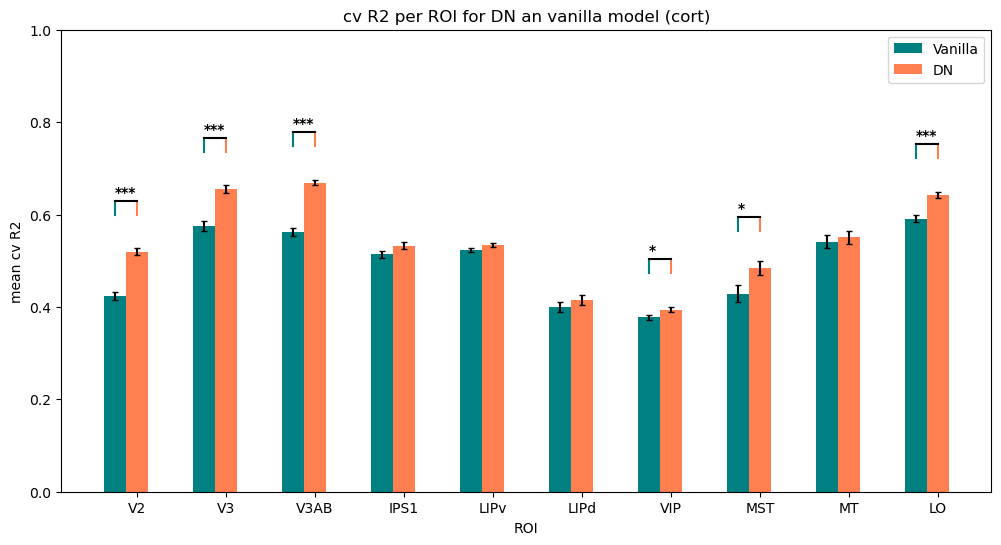

In [32]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = cf_cortical[:,-3]

rdiff2 = np.zeros([118584,])
rdiff2[:] = np.nan
rdiff2[boolmask] = dncf_cortical[:,-3]


width = 0.25
cs = 2

plt.figure(figsize=(12, 6))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    if l ==0:
        print(f_oneway(np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2])))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar2()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, label='Vanilla', color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, label='DN', color='coral', yerr=error2, capsize=cs)

    else:
        print(f_oneway(rdiff[boolmask2],rdiff2[boolmask2]))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar2()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, color='coral', yerr=error2, capsize=cs)

    plt.title(f'cv R2 per ROI for DN an vanilla model (cort)')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:]))+0.25, list(roi_index_dict2)[12:])
plt.ylabel('mean cv R2')
plt.ylim([0, 1])
plt.xlabel('ROI')
plt.legend()

plt.savefig('/tank/klundert/DN.png')

V2
F_onewayResult(statistic=30.54399098164489, pvalue=6.250269070687346e-14)
V3
F_onewayResult(statistic=17.592932670861362, pvalue=2.4534954743565288e-08)
V3AB
F_onewayResult(statistic=nan, pvalue=nan)
IPS1
F_onewayResult(statistic=nan, pvalue=nan)
LIPv
F_onewayResult(statistic=nan, pvalue=nan)
LIPd
F_onewayResult(statistic=nan, pvalue=nan)
VIP
F_onewayResult(statistic=nan, pvalue=nan)
MST
F_onewayResult(statistic=0.40148421230975795, pvalue=0.6694585165540229)
MT
F_onewayResult(statistic=nan, pvalue=nan)
LO
F_onewayResult(statistic=2.5529019195517195, pvalue=0.0781295123170029)


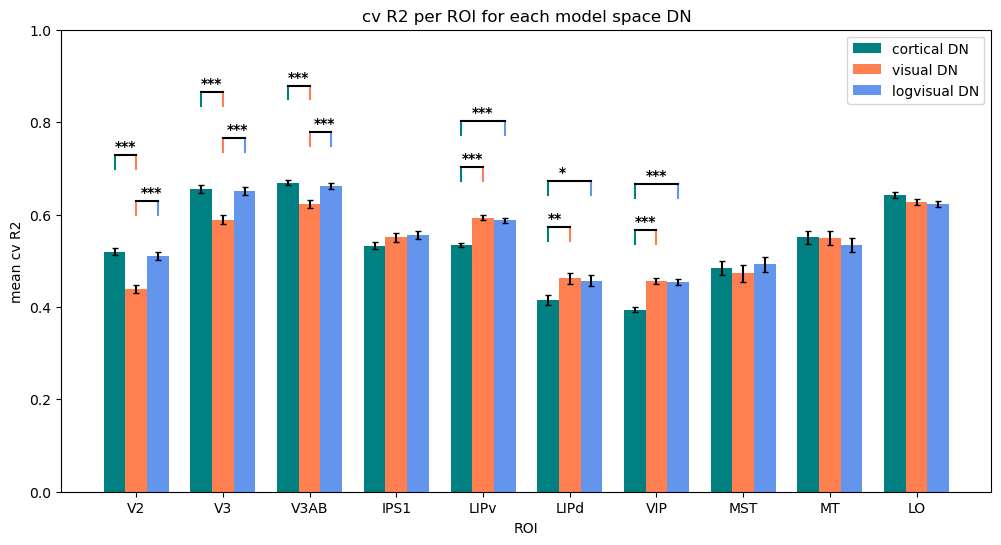

In [33]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,-3]

rdiff2 = np.zeros([118584,])
rdiff2[:] = np.nan
rdiff2[boolmask] = dncf_vis[:,-3]

rdiff3 = np.zeros([118584,])
rdiff3[:] = np.nan
rdiff3[boolmask] = dncf_logvis[:,-3]

rdiff4 = np.zeros([118584,])
rdiff4[:] = np.nan
rdiff4[boolmask] = cf_cortical[:,-3]


width = 0.25
cs = 2


plt.figure(figsize=(12, 6))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    if l ==0:
        print(f_oneway(np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, label='cortical DN', color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, label='visual DN', color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, label='logvisual DN', color='cornflowerblue', yerr=error3, capsize=cs)

    else:
        print(f_oneway(rdiff[boolmask2],rdiff2[boolmask2],rdiff3[boolmask2]))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, color='cornflowerblue', yerr=error3, capsize=cs)
        
    plt.title(f'cv R2 per ROI for each model space DN')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:]))+0.25, list(roi_index_dict2)[12:])
plt.ylabel('mean cv R2')
plt.ylim([0, 1])
plt.xlabel('ROI')
plt.legend()

V2
F_onewayResult(statistic=30.54399098164489, pvalue=6.250269070687346e-14)
V3
F_onewayResult(statistic=17.592932670861362, pvalue=2.4534954743565288e-08)
V3AB
F_onewayResult(statistic=nan, pvalue=nan)
IPS1
F_onewayResult(statistic=nan, pvalue=nan)
LIPv
F_onewayResult(statistic=nan, pvalue=nan)
LIPd
F_onewayResult(statistic=nan, pvalue=nan)
VIP
F_onewayResult(statistic=nan, pvalue=nan)
MST
F_onewayResult(statistic=0.40148421230975795, pvalue=0.6694585165540229)
MT
F_onewayResult(statistic=nan, pvalue=nan)
LO
F_onewayResult(statistic=2.5529019195517195, pvalue=0.0781295123170029)
V2
V3
V3AB
IPS1
LIPv
LIPd
VIP
MST
MT
LO


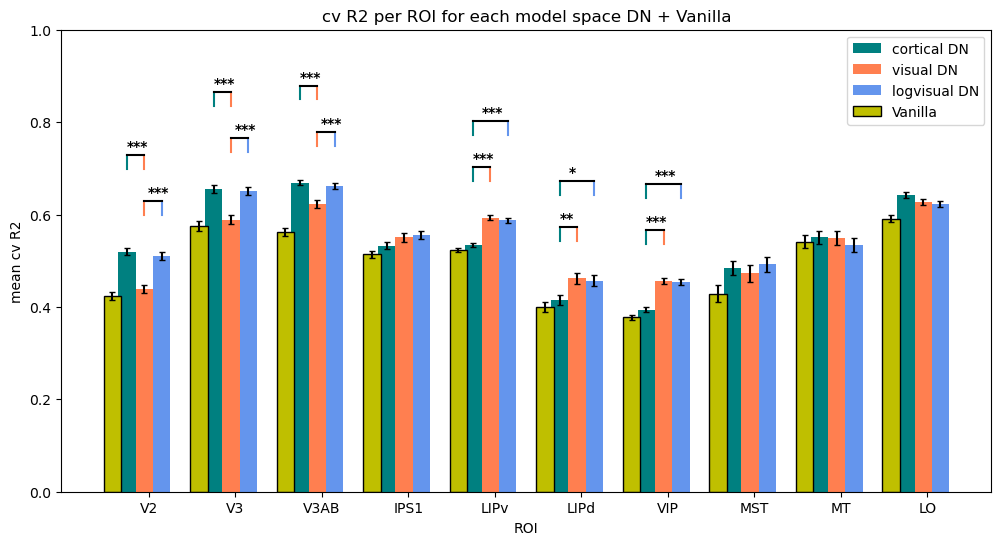

In [34]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,-3]

rdiff2 = np.zeros([118584,])
rdiff2[:] = np.nan
rdiff2[boolmask] = dncf_vis[:,-3]

rdiff3 = np.zeros([118584,])
rdiff3[:] = np.nan
rdiff3[boolmask] = dncf_logvis[:,-3]

rdiff4 = np.zeros([118584,])
rdiff4[:] = np.nan
rdiff4[boolmask] = cf_cortical[:,-3]


width = 0.20
cs = 2


plt.figure(figsize=(12, 6))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    if l ==0:
        print(f_oneway(np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, label='cortical DN', color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, label='visual DN', color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, label='logvisual DN', color='cornflowerblue', yerr=error3, capsize=cs)

    else:
        print(f_oneway(rdiff[boolmask2],rdiff2[boolmask2],rdiff3[boolmask2]))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        add_sign_plot_bar()
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, color='cornflowerblue', yerr=error3, capsize=cs)



for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    if l ==0:

        error = sem(np.nan_to_num(rdiff4[boolmask2]))
        plt.bar(l-0.17, np.nanmean(rdiff4[boolmask2]), width = width, label='Vanilla', edgecolor='black',color='y', yerr=error, capsize=cs)

    else:
        error = sem(np.nan_to_num(rdiff4[boolmask2]))
        plt.bar(l-0.17, np.nanmean(rdiff4[boolmask2]), width = width, edgecolor='black', color='y', yerr=error, capsize=cs)


    plt.title(f'cv R2 per ROI for each model space DN + Vanilla')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:]))+0.25, list(roi_index_dict2)[12:])
plt.ylabel('mean cv R2')
plt.ylim([0, 1])
plt.xlabel('ROI')
plt.legend()
plt.savefig('/tank/klundert/DN_spaces.png')

/tmp/ipykernel_1913618/3486350126.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
/tmp/ipykernel_1913618/3486350126.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df3, ignore_index=True)
/tmp/ipykernel_1913618/3486350126.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
/tmp/ipykernel_1913618/3486350126.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
/tmp/ipykernel_1913618/3486350126.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

V2
          1         2         3
1  1.000000  0.013177  0.570164
2  0.013177  1.000000  0.034637
3  0.570164  0.034637  1.000000
V3
F_onewayResult(statistic=5.60987359080324, pvalue=0.003687692713544325)
          1         2         3
1  1.000000  0.005617  0.624818
2  0.005617  1.000000  0.014230
3  0.624818  0.014230  1.000000
V3AB
F_onewayResult(statistic=2.0109425129723397, pvalue=0.134090215259407)
          1         2         3
1  1.000000  0.128993  0.128993
2  0.128993  1.000000  0.927644
3  0.128993  0.927644  1.000000
IPS1
F_onewayResult(statistic=2.295332550438059, pvalue=0.10110738132681307)
         1        2        3
1  1.00000  0.59062  0.15204
2  0.59062  1.00000  0.15204
3  0.15204  0.15204  1.00000
LIPv
F_onewayResult(statistic=44.66079664111875, pvalue=1.413021040111114e-19)
              1             2             3
1  1.000000e+00  1.333575e-14  1.955946e-17
2  1.333575e-14  1.000000e+00  4.857557e-01
3  1.955946e-17  4.857557e-01  1.000000e+00
LIPd
F_onewayR

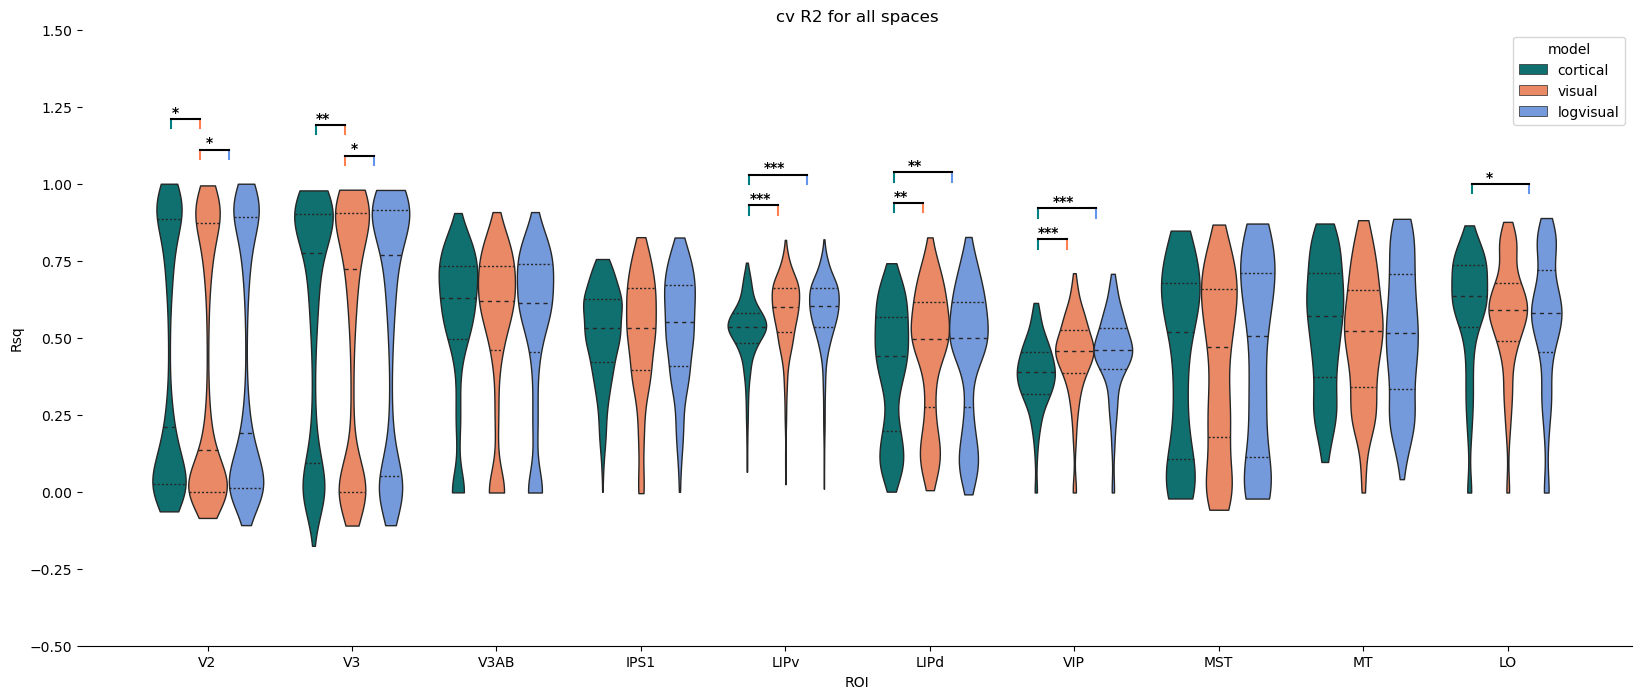

In [35]:
from matplotlib.pyplot import rcParams
import seaborn as sns

rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = cf_cortical[:,-3]

rdiff2 = np.zeros([118584,])
rdiff2[:] = np.nan
rdiff2[boolmask] = cf_vis[:,-3]

rdiff3 = np.zeros([118584,])
rdiff3[:] = np.nan
rdiff3[boolmask] = cf_logvis[:,-3]


for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    if l == 0:
        boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
        df = pd.DataFrame(rdiff[boolmask2])
        df['ROI'] = f'{ROI}'
        df['model'] = 'cortical'
        
        df2 = pd.DataFrame(rdiff2[boolmask2])
        df2['ROI'] = f'{ROI}'
        df2['model'] = 'visual'
        
        df3 = pd.DataFrame(rdiff3[boolmask2])
        df3['ROI'] = f'{ROI}'
        df3['model'] = 'logvisual'
        
        df = df.append(df2, ignore_index=True)
        df = df.append(df3, ignore_index=True)
        
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    df2 = pd.DataFrame(rdiff[boolmask2])
    df2['ROI'] = f'{ROI}'
    df2['model'] = 'cortical'
    df = df.append(df2, ignore_index=True)
    
    df2 = pd.DataFrame(rdiff2[boolmask2])
    df2['ROI'] = f'{ROI}'
    df2['model'] = 'visual'
    df = df.append(df2, ignore_index=True)
    
    df2 = pd.DataFrame(rdiff3[boolmask2])
    df2['ROI'] = f'{ROI}'
    df2['model'] = 'logvisual'
    df = df.append(df2, ignore_index=True)
    

    
df.columns =['Rsq', 'ROI', 'model']    

rcParams['figure.figsize'] = 20,8

# Draw a nested violinplot and split the violins for easier comparison
violin = sns.violinplot(data=df, x="ROI", y='Rsq', hue="model", legend=False, cut=0, palette=["teal", "coral", "cornflowerblue"],
               inner="quart", linewidth=1).set(title=f'cv R2 for all spaces')

plt.ylim(-0.5,1.5)
# plt.legend().remove()
sns.despine(left=True)
# ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
#                     data=tips, palette="muted")


for l, ROI in enumerate(list(roi_index_dict2)[12:]):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    if l ==0:
#         print(f_oneway(np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        print(tt)
        l = l-0.25
        add_sign_plot_violin()

    else:
        l = l-0.25
        print(f_oneway(rdiff[boolmask2],rdiff2[boolmask2],rdiff3[boolmask2]))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        tt = sp.posthoc_ttest(x, p_adjust = 'fdr_bh')
        print(tt)
        add_sign_plot_violin()



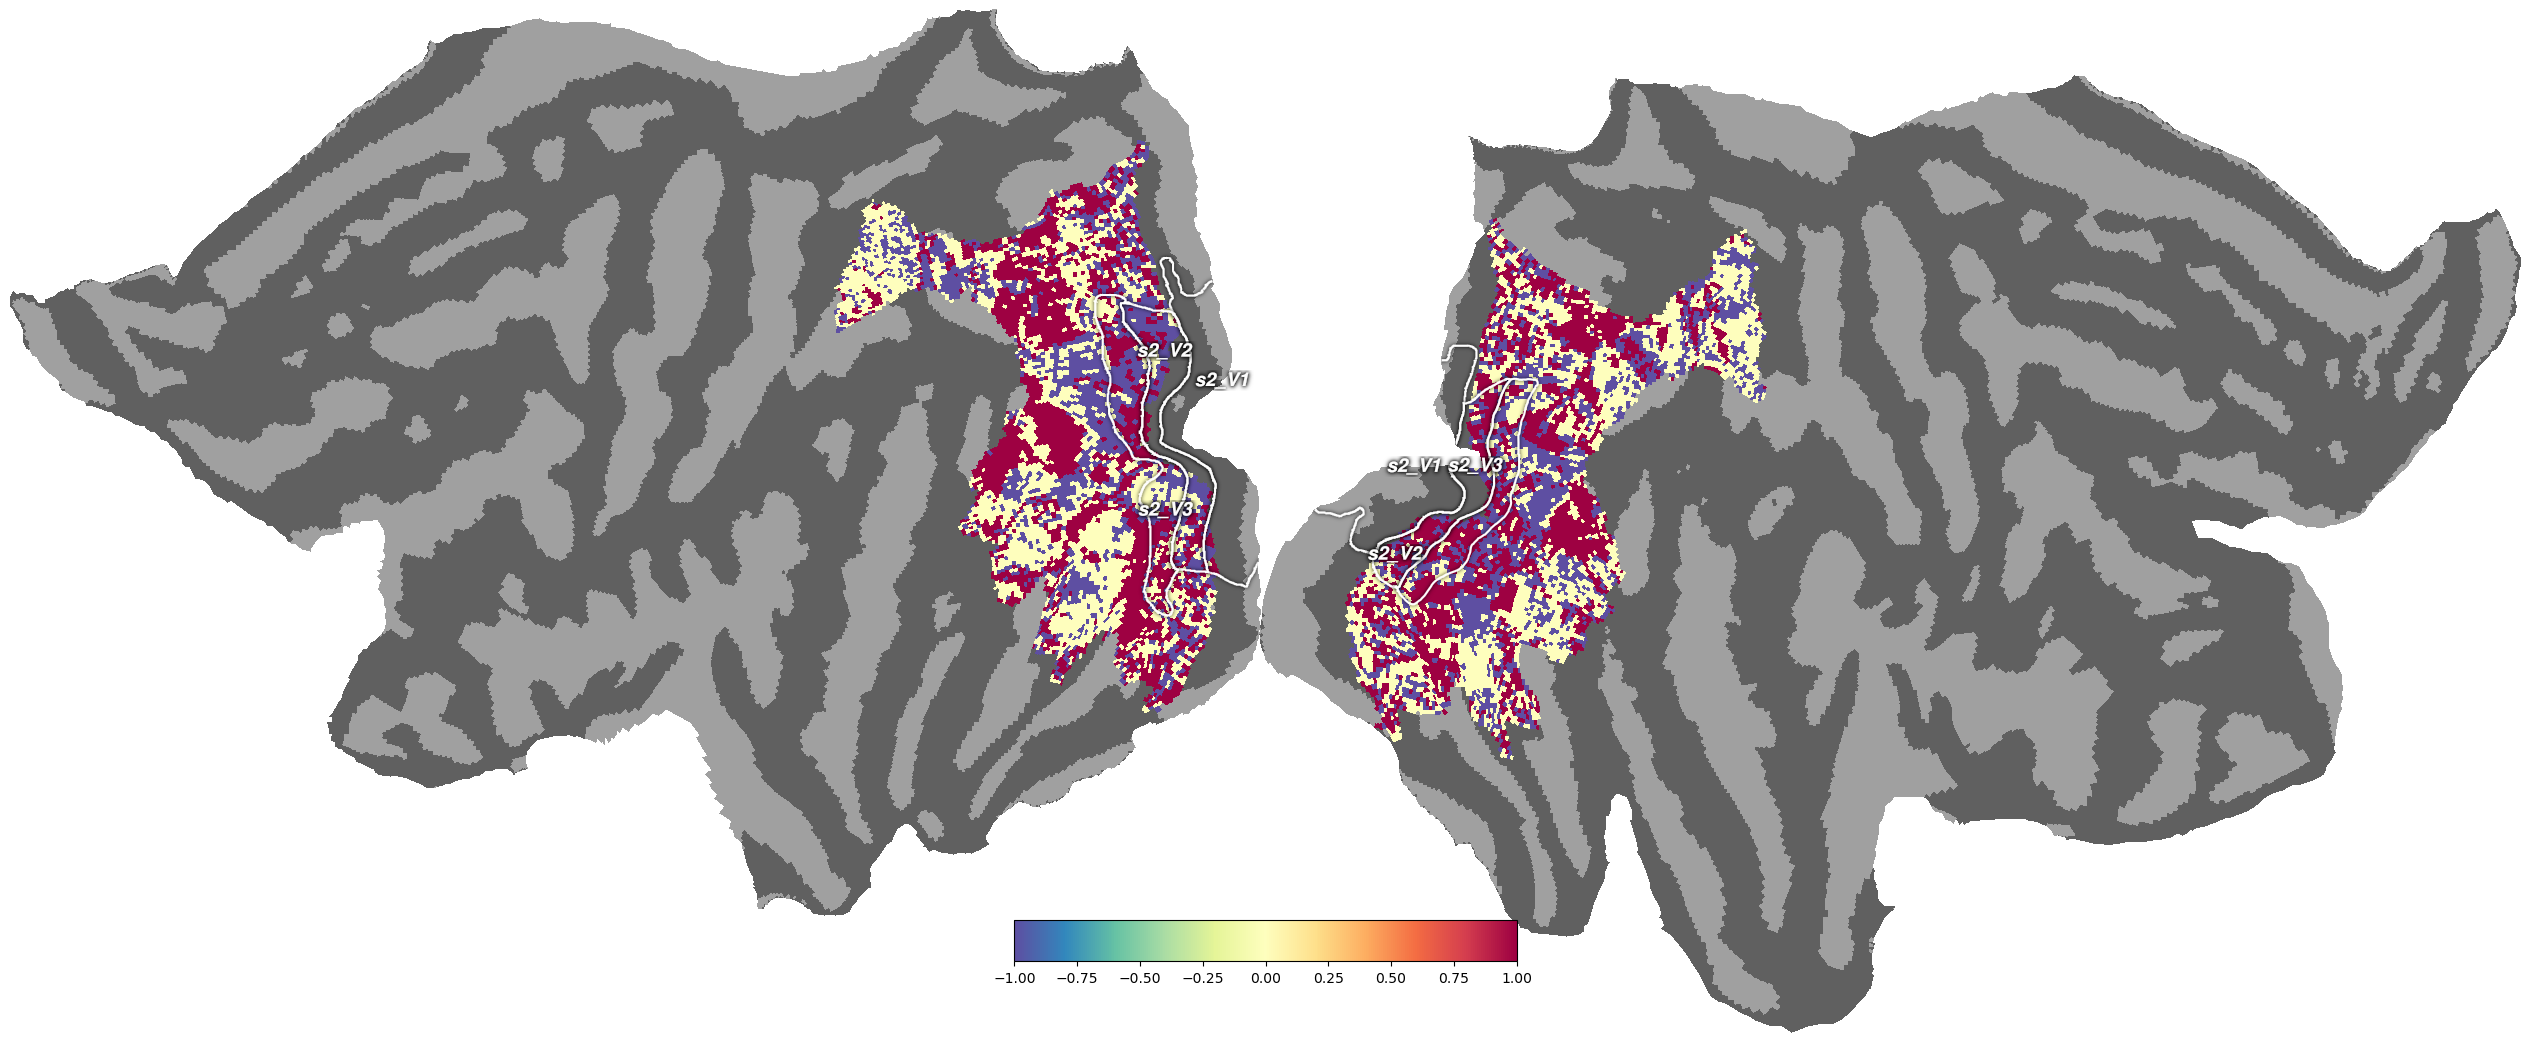

In [39]:
test1 = np.zeros([118584,])
test1[:] = np.nan
test1[boolmask] = cf_logvis[:,-3]

test2 = np.zeros([118584,])
test2[:] = np.nan
test2[boolmask] = cf_vis[:,-3]

test3 = np.zeros([118584,])
test3[:] = np.nan
test3[boolmask] = cf_cortical[:,-3]

test1_scaled = np.asarray((test1 > test2) * (test1 > test3) * -1)
test2_scaled = np.asarray((test2 > test1) * (test2 > test3) * 0)
test3_scaled = np.asarray((test3 > test2) * (test3 > test1) * 1)


BM = np.zeros([118584,])
BM[:] = np.nan
BM[boolmask] = test1_scaled[boolmask] + test2_scaled[boolmask] + test3_scaled[boolmask]


vol_data = cx.Vertex(BM, subject='hcp_999999', cmap='spectral_r')
cx.quickshow(vol_data, with_colorbar=True, with_curvature=True)
plt.show()

In [ ]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[boolmask] = dncf_cortical[:,-3] - cf_cortical[:,-3]
bl = get_blend(cx.Vertex(toplot, subject='hcp_999999', cmap='spectral_r', vmin=-0.05, vmax=0.05))
cx.webgl.show(bl, port=8810, recache=True);

In [37]:
roi_index_dict3 = {
    'Early_visual': [4, 5, 6],
    'Ventral_stream': [7, 18, 22, 153, 154, 160, 163],
    'Dorsal_stream': [3, 13,  16,  17,  19, 152],
    'MT+_Complex_+Neighboring': [2,  20,  21,  23, 138, 156, 157, 158, 159]
    }

Early_visual
F_onewayResult(statistic=44.72465462152614, pvalue=4.3406160903173647e-20)
              1             2             3
1  1.000000e+00  2.441883e-16  4.725219e-01
2  2.441883e-16  1.000000e+00  4.770384e-14
3  4.725219e-01  4.770384e-14  1.000000e+00
Ventral_stream
F_onewayResult(statistic=nan, pvalue=nan)
          1         2         3
1  1.000000  0.878616  0.878616
2  0.878616  1.000000  0.878616
3  0.878616  0.878616  1.000000
Dorsal_stream
F_onewayResult(statistic=nan, pvalue=nan)
              1             2             3
1  1.000000e+00  3.540526e-13  1.777342e-01
2  3.540526e-13  1.000000e+00  2.180401e-09
3  1.777342e-01  2.180401e-09  1.000000e+00
MT+_Complex_+Neighboring
F_onewayResult(statistic=nan, pvalue=nan)
          1         2         3
1  1.000000  0.673519  0.673519
2  0.673519  1.000000  0.673519
3  0.673519  0.673519  1.000000


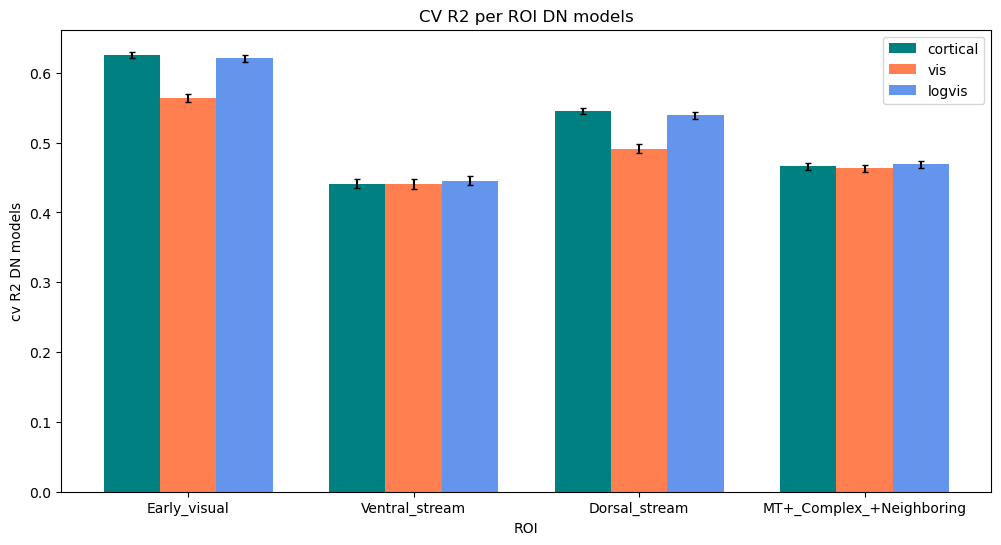

In [40]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,-3]

rdiff2 = np.zeros([118584,])
rdiff2[:] = np.nan
rdiff2[boolmask] = dncf_vis[:,-3] 

rdiff3 = np.zeros([118584,])
rdiff3[:] = np.nan
rdiff3[boolmask] = dncf_logvis[:,-3]


width = 0.25
cs = 2

# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 6))
for l, ROI in enumerate(list(roi_index_dict3)):
    print(ROI)
    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict3[ROI])
    if l ==0:
        print(f_oneway(np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        print(sp.posthoc_ttest(x, p_adjust = 'fdr_bh'))
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, label='cortical', color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, label='vis', color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, label='logvis', color='cornflowerblue', yerr=error3, capsize=cs)
#         plt.bar(l+0.45, np.nanmean(rdiff3[boolmask2]), width = 0.15, label='logvis', color='red')
    else:
        print(f_oneway(rdiff[boolmask2],rdiff2[boolmask2],rdiff3[boolmask2]))
        x = [np.nan_to_num(rdiff[boolmask2]),np.nan_to_num(rdiff2[boolmask2]),np.nan_to_num(rdiff3[boolmask2])]
        print(sp.posthoc_ttest(x, p_adjust = 'fdr_bh'))
        error = sem(np.nan_to_num(rdiff[boolmask2]))
        plt.bar(l, np.nanmean(rdiff[boolmask2]), width = width, color='teal', yerr=error, capsize=cs)
        error2 = sem(np.nan_to_num(rdiff2[boolmask2]))
        plt.bar(l+width, np.nanmean(rdiff2[boolmask2]), width = width, color='coral', yerr=error2, capsize=cs)
        error3 = sem(np.nan_to_num(rdiff3[boolmask2]))
        plt.bar(l+width*2, np.nanmean(rdiff3[boolmask2]), width = width, color='cornflowerblue', yerr=error3, capsize=cs)
#         plt.bar(l+0.45, np.nanmean(rdiff3[boolmask2]), width = 0.15, color='red')


#     plt.hist(diff[boolmask2], bins=100, range=[-1,60])
    plt.title(f'CV R2 per ROI DN models')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict3)))+0.25, list(roi_index_dict3))
plt.ylabel('cv R2 DN models')
# plt.ylim([0, 0.8])
plt.xlabel('ROI')
plt.legend()

Text(0.5, 0, 'ROI')

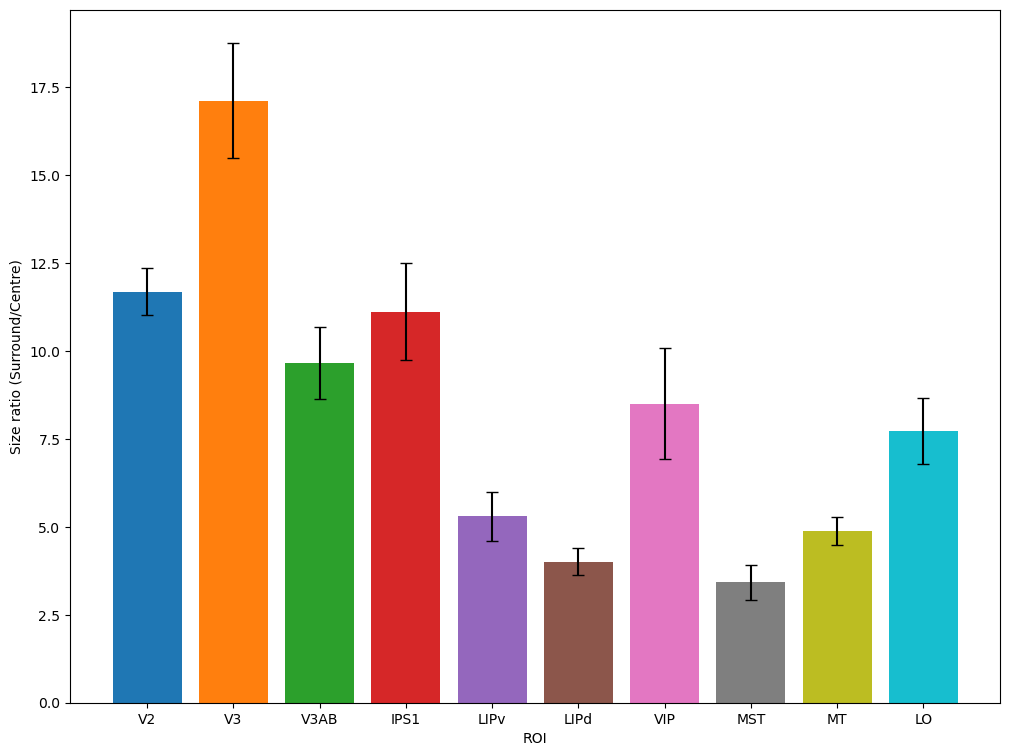

In [41]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,5] / dncf_cortical[:,0]
# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 9))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):

    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    error = sem(np.nan_to_num(rdiff[boolmask2]))
    plt.bar(l, np.nanmean(rdiff[boolmask2]), yerr=error, capsize=4)
#     plt.bar(l, np.nanmean(rdiff[boolmask2]))

#     plt.hist(diff[boolmask2], bins=100, range=[-1,60])
#     plt.title(f'Size ratio (Surround/Centre) - DN')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:])), list(roi_index_dict2)[12:])
plt.ylabel('Size ratio (Surround/Centre)')
plt.xlabel('ROI')

In [69]:
boolmask = np.load('/tank/klundert/DMs/combmask_sub-01.npy')

(0.0, 20.0)

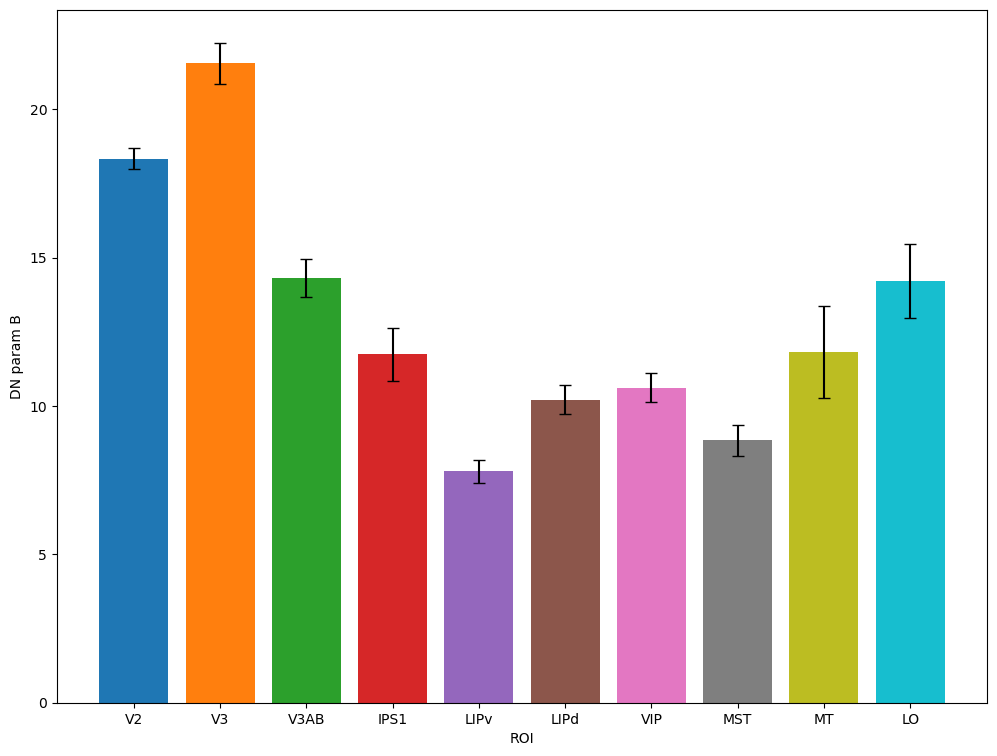

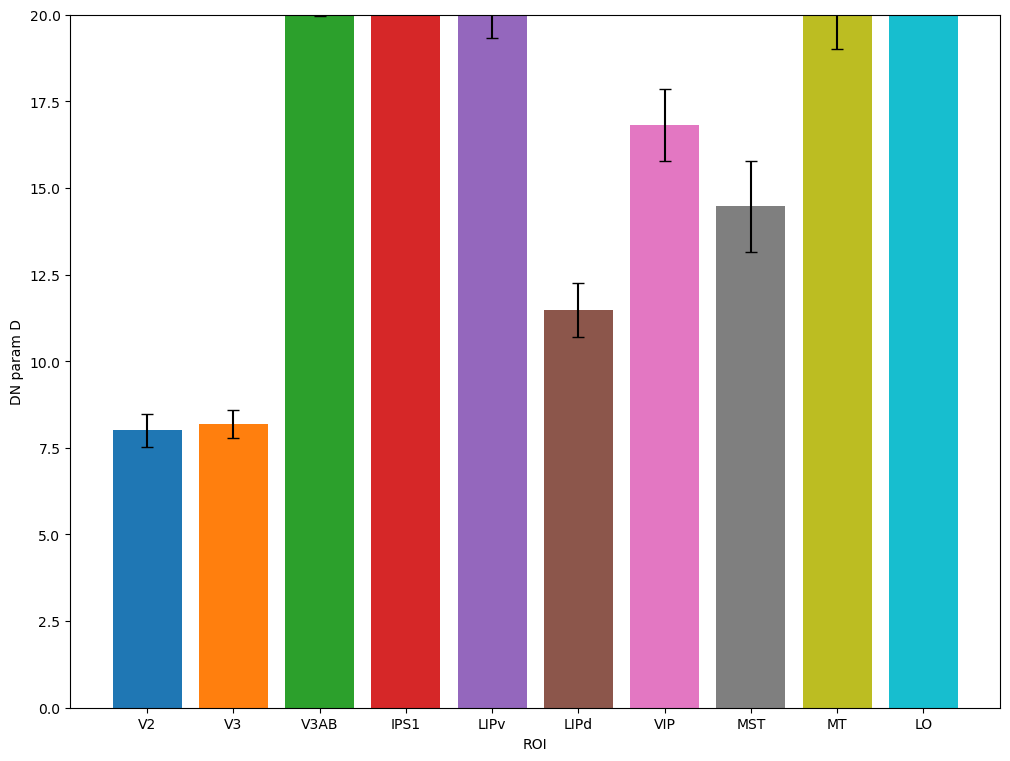

In [72]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,6]
# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 9))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):

    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    

#     error = sem(np.nan_to_num(rdiff[boolmask2][(np.abs(stats.zscore(np.nan_to_num(rdiff[boolmask2]))) < 0.1)]))
    error = sem(np.nan_to_num(rdiff[boolmask2]))
  
    plt.bar(l, np.nanmean(rdiff[boolmask2]), yerr=error, capsize=4)
    
    
#     plt.title(f'DN param B - logvisual space')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:])), list(roi_index_dict2)[12:])
plt.ylabel('DN param B')
plt.xlabel('ROI')
# plt.ylim([0,20])

rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,7]
# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 9))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):

    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    error = sem(np.nan_to_num(rdiff[boolmask2]))



    plt.bar(l, np.nanmean(rdiff[boolmask2]), yerr=error, capsize=4)
#     plt.bar(l, np.nanmedian(rdiff[boolmask2]))

#     plt.hist(diff[boolmask2], bins=100, range=[-1,60])
#     plt.title(f'DN param D - logvisual space')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:])), list(roi_index_dict2)[12:])
plt.ylabel('DN param D')
plt.xlabel('ROI')
plt.ylim([0, 20])

(0.0, 60.0)

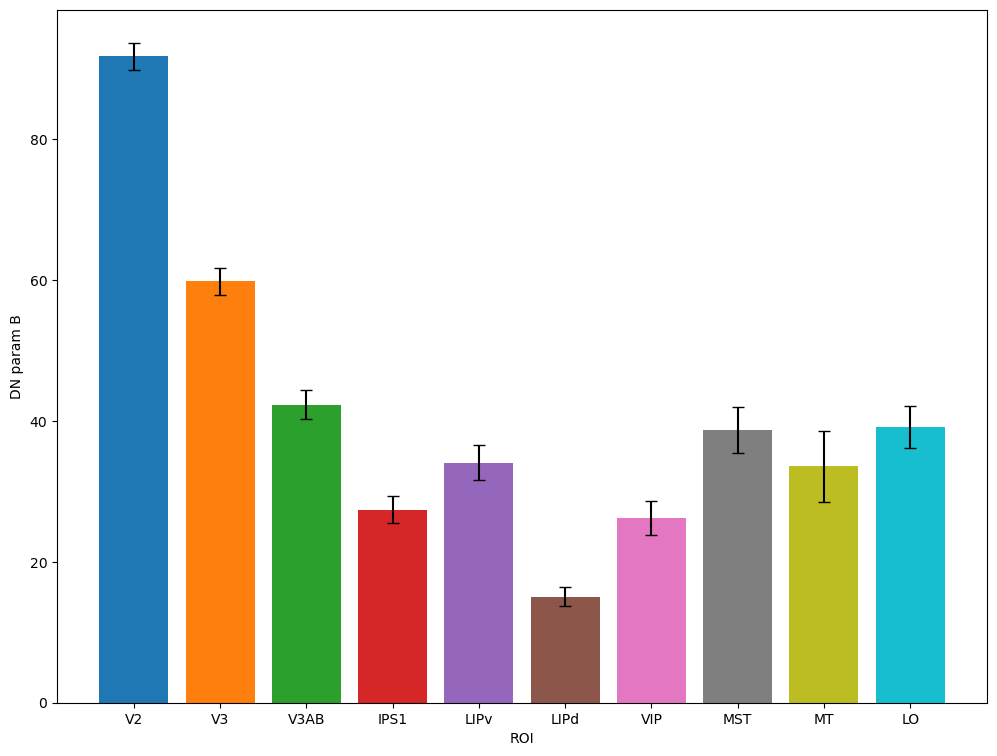

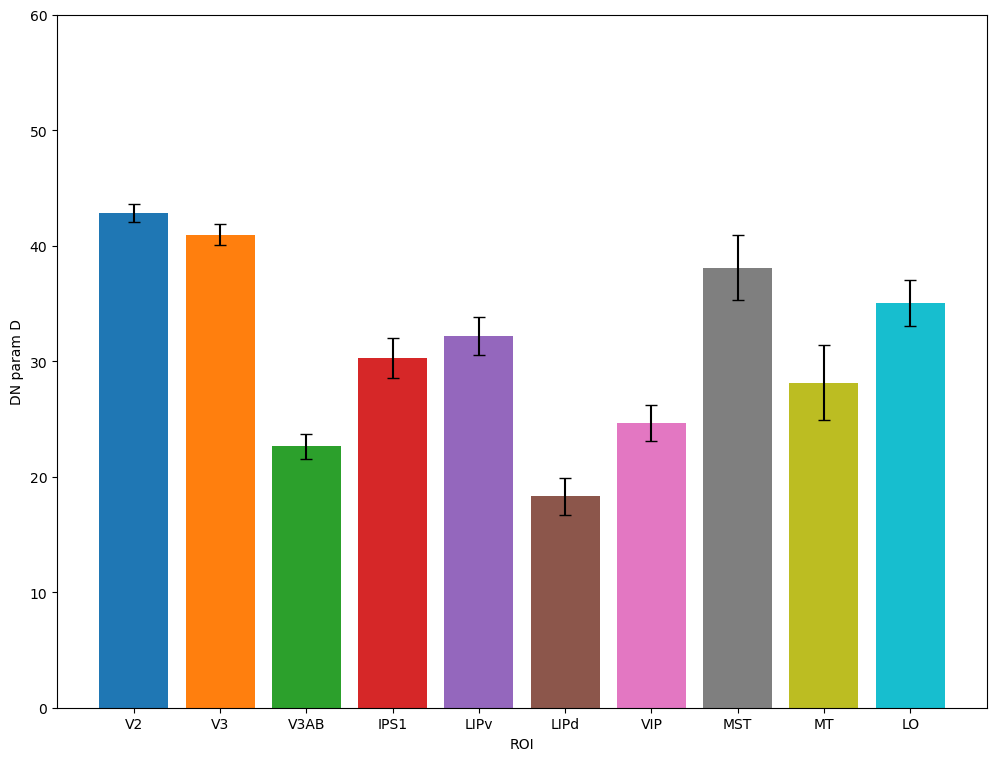

In [25]:
rdiff = np.zeros([118584,])
rdiff[:] = np.nan
dnp1 = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-01/dn-prf/sub-01_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy'))
dnp2 = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-02/dn-prf/sub-02_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy'))
dnp = (dnp1 + dnp2) / 2
dnp[dnp[:,-1 ] < 0.2] = np.nan
rdiff = dnp[:,7]
# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 9))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):

    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    

#     error = sem(np.nan_to_num(rdiff[boolmask2][(np.abs(stats.zscore(np.nan_to_num(rdiff[boolmask2]))) < 0.1)]))
    error = sem(np.nan_to_num(rdiff[boolmask2]))
  
    plt.bar(l, np.nanmean(rdiff[boolmask2]), yerr=error, capsize=4)
    
    
#     plt.title(f'DN param B - logvisual space')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:])), list(roi_index_dict2)[12:])
plt.ylabel('DN param B')
plt.xlabel('ROI')
# plt.ylim([0,20])

rdiff = np.zeros([118584,])
rdiff[:] = np.nan
rdiff[boolmask] = dncf_cortical[:,7]
rdiff = dnp[:,8]

# rduff = norm_avg[:,-1]-gauss_avg[:,-1]
# rdiff = CF_vis_zsc[:,-1] - CF_cort_zsc[:,-1]
plt.figure(figsize=(12, 9))
for l, ROI in enumerate(list(roi_index_dict2)[12:]):

    boolmask2 = np.isin(atlas_data_both_hemis, roi_index_dict2[ROI])
    error = sem(np.nan_to_num(rdiff[boolmask2]))



    plt.bar(l, np.nanmean(rdiff[boolmask2]), yerr=error, capsize=4)
#     plt.bar(l, np.nanmedian(rdiff[boolmask2]))

#     plt.hist(diff[boolmask2], bins=100, range=[-1,60])
#     plt.title(f'DN param D - logvisual space')
    plt.show
    
plt.xticks(np.arange(len(list(roi_index_dict2)[12:])), list(roi_index_dict2)[12:])
plt.ylabel('DN param D')
plt.xlabel('ROI')
plt.ylim([0, 60])

In [ ]:
toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[boolmask] = dncf_vis[:,0]
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='inferno', vmin=0, vmax=15), with_curvature=True);
plt.title('DN vis sigma')

toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[boolmask] = dncf_vis[:,5]
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True);
plt.title('DN vis sigma2')


toplot = np.zeros([118584,])
toplot[:] = np.nan

toplot[boolmask] = dncf_vis[:,5] / dncf_vis[:,0]
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True);
plt.title('DN vis size ratio')


In [ ]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[boolmask] = ecc(cf_vis[:,-1], cf_vis[:,-2])
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True);
plt.title('ecc visual space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[boolmask] = ecc(cf_logvis[:,-1], cf_logvis[:,-2])
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True);
plt.title('ecc log-visual space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot[boolmask] = ecc(cf_cortical[:,-1], cf_cortical[:,-2])
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True);
plt.title('ecc cortical space')

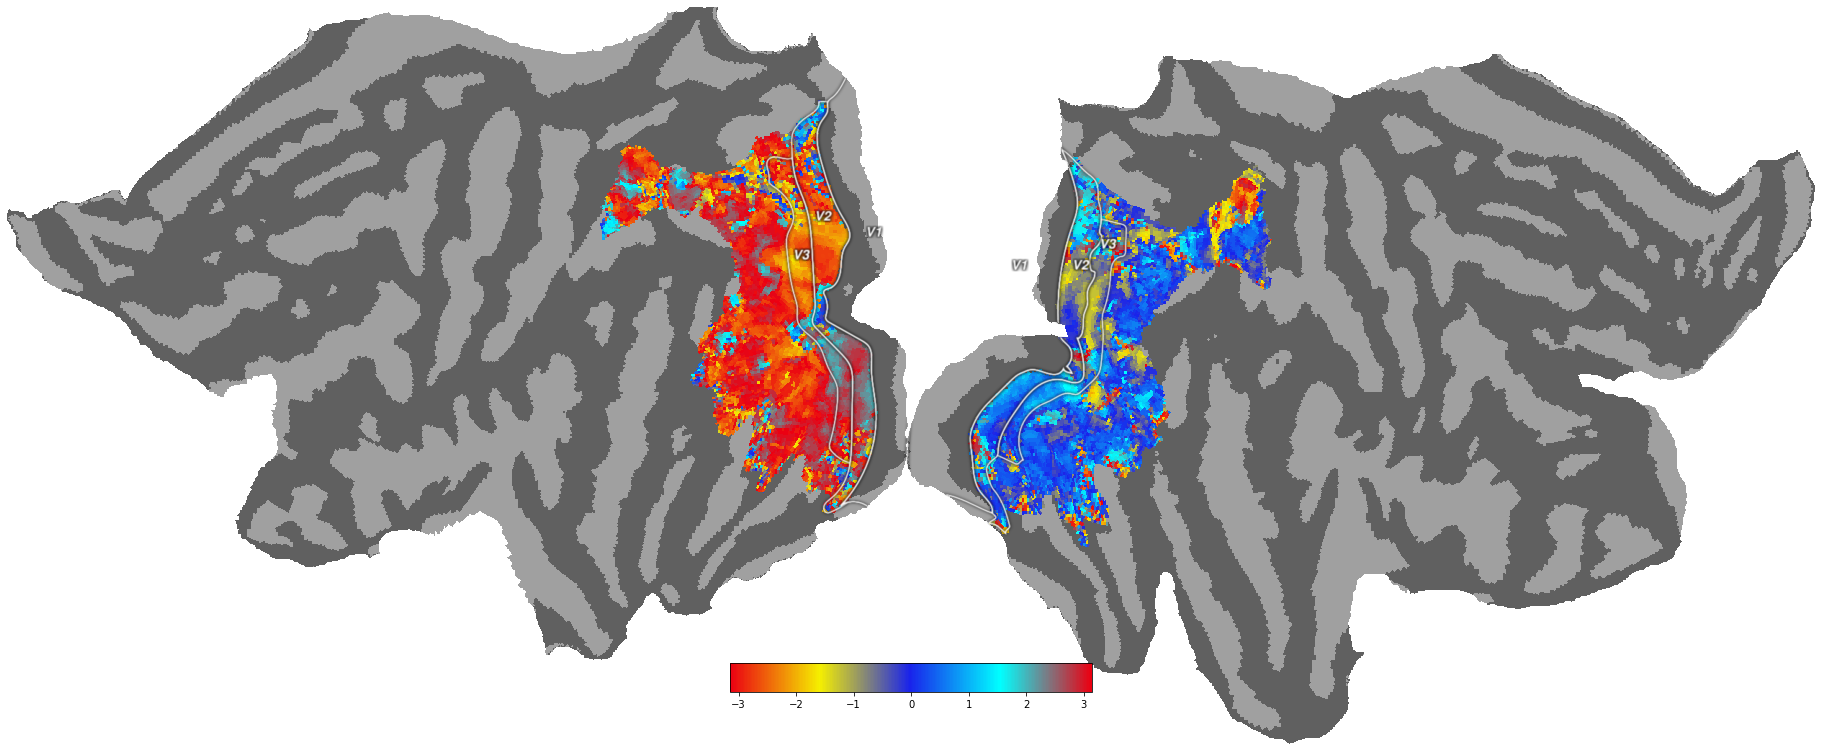

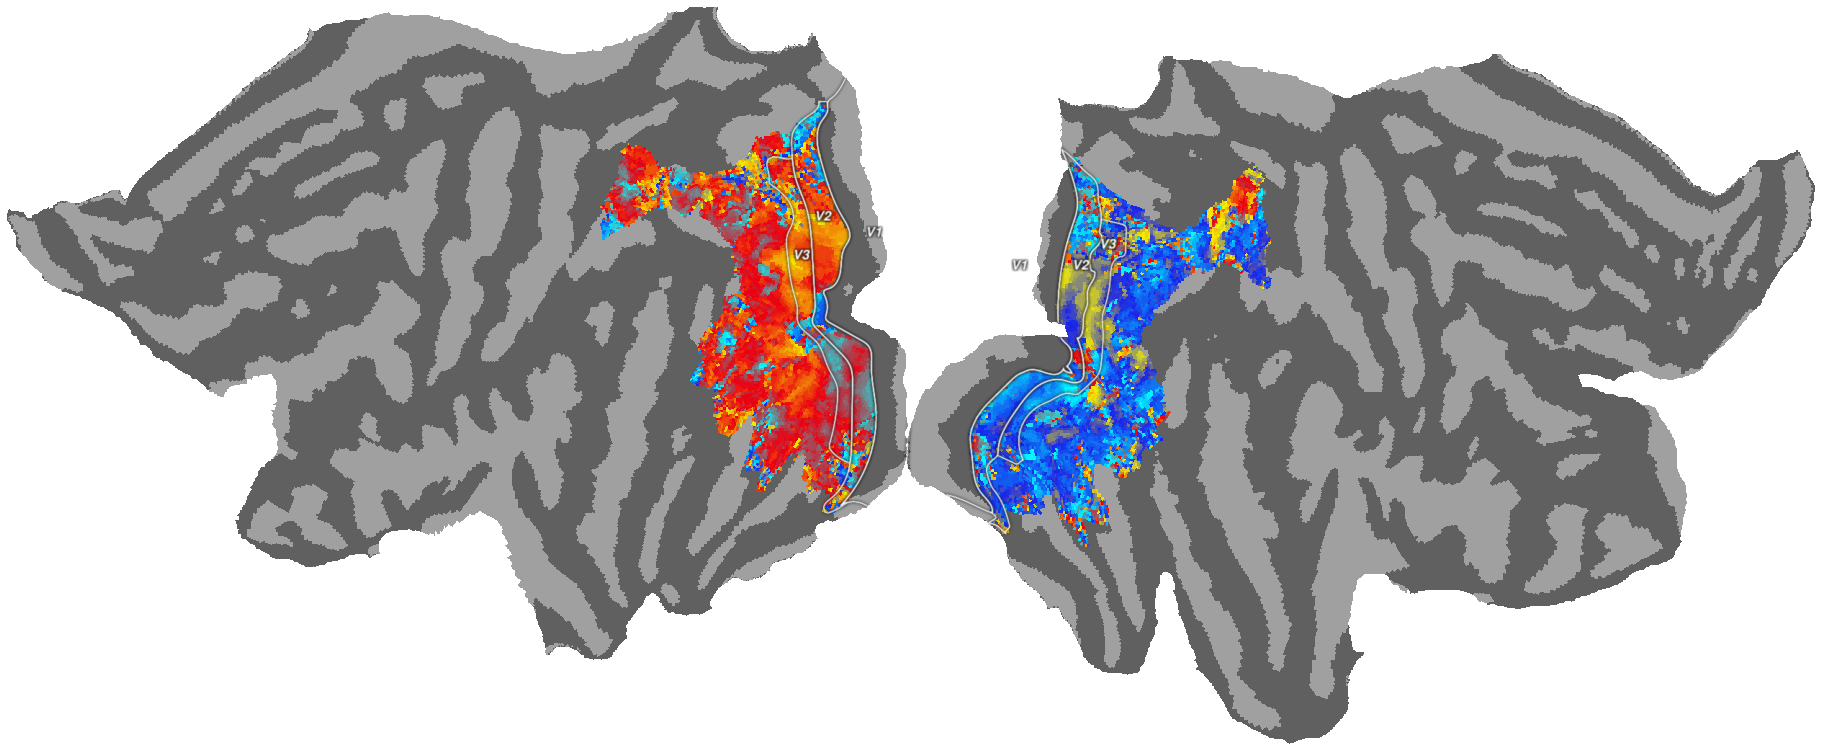

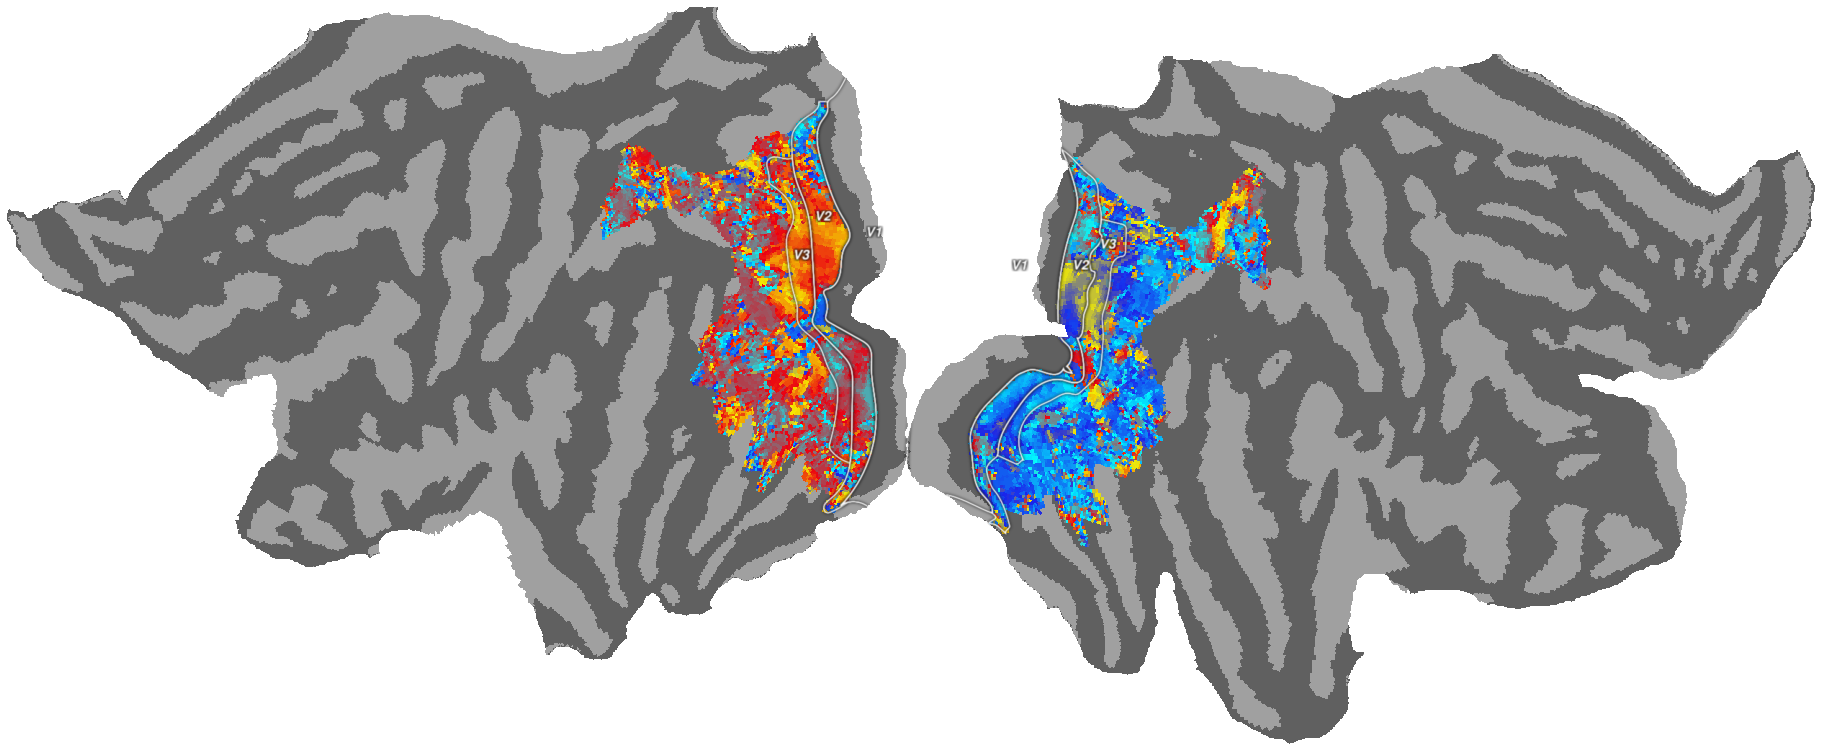

In [89]:
toplot = np.zeros([118584,])
toplot[:] = np.nan
# datass = np.load('/tank/klundert/projects/cfdn/scripts/data_check_100610.npy')
toplot[boolmask] = angle(cf_vis[:,-1], cf_vis[:,-2]*-1)
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi));
# plt.title('polar angle visual space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
# datass = np.load('/tank/klundert/projects/cfdn/scripts/data_check_100610.npy')
toplot[boolmask] = angle(cf_logvis[:,-1], cf_logvis[:,-2]*-1)
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, with_colorbar=False);
# plt.title('polar angle logvisual space')

toplot = np.zeros([118584,])
toplot[:] = np.nan
# datass = np.load('/tank/klundert/projects/cfdn/scripts/data_check_100610.npy')
toplot[boolmask] = angle(cf_cortical[:,-1], cf_cortical[:,-2]*-1)
# toplot[boolmask] = difference
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, with_colorbar=False);
# plt.title('polar angle cortical space')

In [100]:
fold = 1
sub = 2
s2_f = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full_zsc.npy")
s2_f2 = np.load(f"/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full_zsc.npy")  

if fold == 1:
    mydat_train = np.nan_to_num(get_cortex(s2_f)[:,10:])
    mydat_test = np.nan_to_num(get_cortex(s2_f2)[:,10:])
    print("fold 1")
    

roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()

prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])

# create eccentricity mask and combine with Rsq and V1 mask

eccMask = gfn_ecc < 8.91243496952274
maskLecc, maskRecc = splitList(eccMask)

Rsqmask = prf_params[:,-1] > 0.4
rsqL, rsqR = splitList(Rsqmask)

V1mask = np.concatenate([maskL, maskR])

maskLecc = maskLecc*rsqL
maskRecc = maskRecc*rsqR
intmask = np.concatenate([maskLecc, maskRecc])
intmask = intmask * V1mask

distmaskL = maskLecc[maskL]
distmaskR = maskRecc[maskR]

# modify the subsurface distances to only include the vertices we want sample from
# and modify the subsurface_verts to correspond to these vertices we want to sample

myv1surf.dists_R = myv1surf.dists_R[distmaskR][:,distmaskR]
myv1surf.dists_L = myv1surf.dists_L[distmaskL][:,distmaskL]
myv1surf.pad_distance_matrices()
myv1surf.subsurface_verts=np.concatenate([myv1surf.subsurface_verts_L[distmaskL],myv1surf.subsurface_verts_R[distmaskR]])

#     f = cortex.quickshow(cortex.Vertex(intmask.astype(int), subject='hcp_999999', cmap='plasma'), with_curvature=True);
#     f.suptitle('V1 vertices that we sample')

# these should be size (N,) and (N, N)
print(myv1surf.subsurface_verts.shape)
print(myv1surf.distance_matrix.shape)


train_stim_vis=CFStimulus(mydat_train,myv1surf.subsurface_verts,np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-02.npy'))
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-02.npy'))

test_stim_vis=CFStimulus(mydat_test,myv1surf.subsurface_verts,np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-02.npy'))
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-02.npy'))

# Make a model
model=CFGaussianModel(test_stim)
gfdn = Norm_CFGaussianModel(test_stim)
model_vis=CFGaussianModel(train_stim_vis)
gfdn_vis=Norm_CFGaussianModel(train_stim_vis)

fold 1
Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


(933,)
(933, 933)


In [93]:
df = pd.read_csv('/tank/klundert/projects/cfdn/scripts/ROI.csv')

s = df['region'][df['regionID']== atlas_data_both_hemis[433]]



IndexError: index 0 is out of bounds for axis 0 with size 0

In [91]:
difference = dncf_cortical[:,-3] - cf_cortical[:,-3]
gaussr2 = cf_cortical[:,-3]

testmask = (gaussr2 > 0.98)
testmask.sum()

10

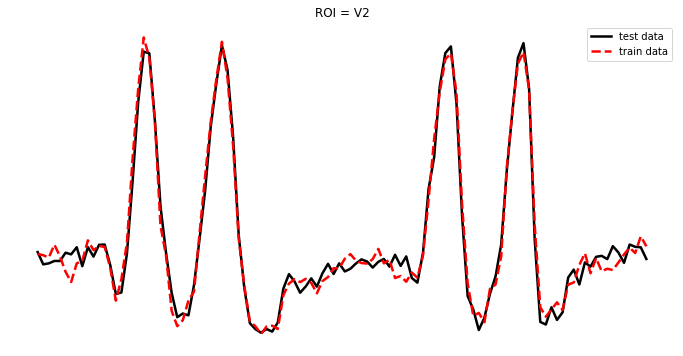

In [98]:
toplot = np.zeros([118584,])
toplot[:] = False
toplot[boolmask] = testmask
inds = np.where(toplot)[0]

for i in range(1):
    i=i
    s = df['region'][df['regionID']== atlas_data_both_hemis[inds[i]].astype(int)]

    Rgauss = np.round(round(cf_cortical[:,-3][testmask][i], 2), 2)
    Rdn = np.round(round(dncf_cortical[:,-3][testmask][i], 2), 2)
    plt.figure(figsize=[12,6])
    plt.plot(mydat_test[boolmask][testmask][i], label='test data', linestyle='-', color='black', linewidth=2.5)
    plt.plot(mydat_train[boolmask][testmask][i], label='train data', linestyle='--', color='red', linewidth=2.5)

    plt.xlabel('time')
    plt.ylabel('BOLD response (z-score)')
    plt.title(f'ROI = {s.values[0]}')

    plt.legend()
    plt.axis('off')
    plt.savefig('/tank/klundert/timecourse.png')

IndexError: index 0 is out of bounds for axis 0 with size 0

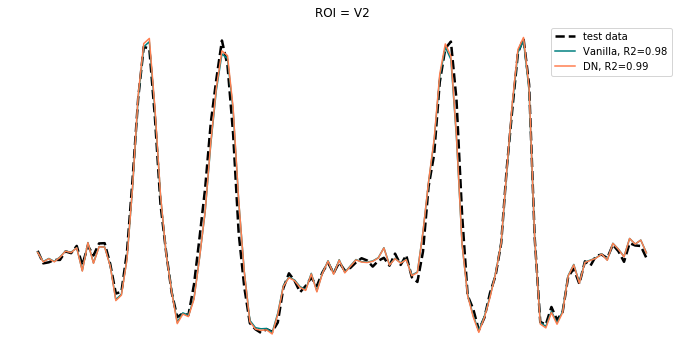

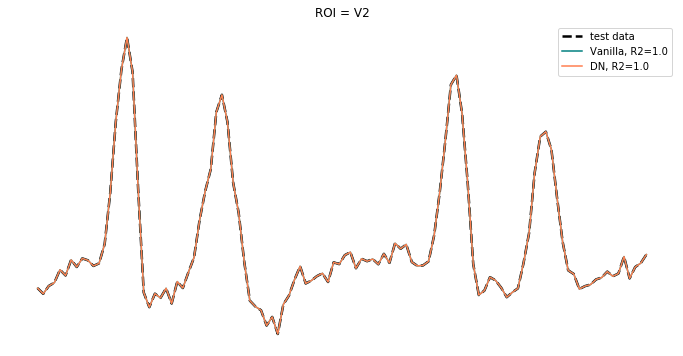

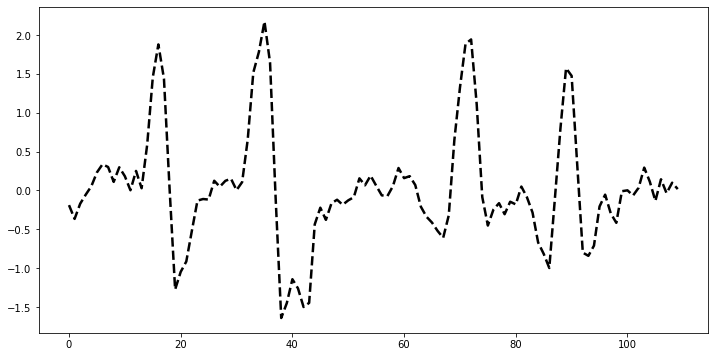

In [103]:
## only works for 1 sub at a time (cant average vertex idx)

toplot = np.zeros([118584,])
toplot[:] = False
toplot[boolmask] = testmask
inds = np.where(toplot)[0]

for i in range(10):
    i=i
#     s = df['region'][df['regionID']== atlas_data_both_hemis[inds[i]].astype(int)]

    Rgauss = np.round(round(cf_cortical[:,-3][testmask][i], 2), 2)
    Rdn = np.round(round(dncf_cortical[:,-3][testmask][i], 2), 2)
    plt.figure(figsize=[12,6])
    plt.plot(mydat_test[boolmask][testmask][i], label='test data', linestyle='--', color='black', linewidth=2.5)
#     plt.plot(mydat_train[boolmask][testmask][i], label='train data', linestyle='--', color='red', linewidth=2.5)

    plt.plot(model.return_prediction(*cf_cortical[testmask][i,:-3]).T, label=f'Vanilla, R2={Rgauss}', c='teal')
    plt.plot(gfdn.return_prediction(*dncf_cortical[testmask][i,:-3]).T, label=f'DN, R2={Rdn}', c='coral')
    plt.xlabel('time')
    plt.ylabel('BOLD response (z-score)')
    plt.title(f'ROI = {s.values[0]}')

    plt.legend()
    plt.axis('off')
    plt.savefig('/tank/klundert/timecourse.png')
